In [8]:
# Import libraries
import numpy as np
import stackstac
import pystac_client
import planetary_computer
import xrspatial.multispectral as ms
import dask.array as da
from dask.distributed import Client, LocalCluster
from urllib3.util.retry import Retry
from dask.diagnostics import ProgressBar
import xarray as xr
import bottleneck
import matplotlib.pyplot as plt
import matplotlib as mpl
import rioxarray
import os
import ipyleaflet

In [18]:
months = ['june', 'july', 'august']
years = ['2018','2019','2020','2021', '2022', '2023']

local = True # This controls whether or not a cluster is created using Coiled as the provisioning service, for testing a local cluster is recommended.
resolution = 10 # This controls the spatial resolution of the fetched datasets - this is changed dynamically using resampling by StackSTAC
bands = ['B02', 'B03', 'B04', 'SCL'] # This controls the bands of the input data to fetch. B02 (blue), B03 (green), and B04 (red) are needed for RGB visualization. SCL is always needed for cloud masking, but the others can be picked as you choose (see Sentinel 2 documentation for band names and descriptions.)

In [10]:
# Set parameters and initialize pystac + coiled
# The retry parameter is used for accessing the STAC catalog, as recommmended by Microsoft.

retry = Retry(
    total=5, backoff_factor=1, status_forcelist=[502, 503, 504], allowed_methods=None
)
pystac_client.stac_api_io.StacApiIO(max_retries=retry)


# If the local parameter is set to true, skip importing Coiled and just make a cluster on this local machine. Workers is automatically equal to the number of cores of your processor in that case.
if local:
    cluster = LocalCluster(name = "Linnars-Dator")
    client = Client(cluster)
else:
    import coiled # See the documentation available for Coiled on how to set up Coiled + Dask!
    cluster = coiled.Cluster(name="WetlandsClassification", shutdown_on_close=True)
    cluster.adapt(n_workers = 1, maximum=10)
    client = cluster.get_client()

c:\Users\linna\anaconda3\envs\my_clean_env\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60382 instead
  warnings.warn(


In [11]:
m = ipyleaflet.Map(scroll_wheel_zoom=True)
m.center = 41.64933994767867, -69.94438630063088
m.zoom = 12
m.layout.height = "800px"
m

Map(center=[41.64933994767867, -69.94438630063088], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [21]:
bbox = (m.west, m.south, m.east, m.north)

In [22]:
catalog = pystac_client.Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1",
modifier=planetary_computer.sign_inplace,
)

# Create an itemcollection
search = catalog.search(
collections=["sentinel-2-l2a"],
bbox=bbox
)

items = search.item_collection()
print(f"\nFound {len(items)} items")


Found 725 items


In [23]:
data = (
    stackstac.stack(
        items,
        assets=bands,  # The selected bands from the assets list 
        resolution=resolution,
        epsg=3006,
        chunksize= (-1, 1, 128, 128),
        bounds_latlon = bbox
    )
)

print("Array size information:")
print(f"Shape: {data.shape}")
print(f"Size in bytes: {data.data.nbytes}")
print(f"Size in GB: {data.data.nbytes / 1e9:.2f} GB")
print(f"Number of chunks: {data.data.npartitions}")
print(f"Chunksize: {(data.data.nbytes / data.data.npartitions) / 1e6:.2f} MB")

data

Array size information:
Shape: (725, 4, 102, 114)
Size in bytes: 269769600
Size in GB: 0.27 GB
Number of chunks: 4
Chunksize: 67.44 MB


<xarray.DataArray 'stackstac-5b245b82d87785a46d1992b4458d3d9e' (time: 725,
                                                                band: 4,
                                                                y: 102, x: 114)> Size: 270MB
dask.array<fetch_raster_window, shape=(725, 4, 102, 114), dtype=float64, chunksize=(725, 1, 102, 114), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 6kB 2015-0...
    id                                       (time) <U54 157kB 'S2A_MSIL2A_20...
  * band                                     (band) <U3 48B 'B02' ... 'SCL'
  * x                                        (x) float64 912B 2.352e+06 ... 2...
  * y                                        (y) float64 816B 3.64e+06 ... 3....
    s2:reflectance_conversion_factor         (time) float64 6kB 0.9756 ... 0....
    ...                                       ...
    gsd                                      (band) float64 32B 10.0 ... 20.0
    proj:bbox                                object 8B {600000.0, 3500040.0, ...
    common_name                              (band) object 32B 'blue' ... None
    center_wavelength                        (band) object 32B 0.49 ... None
    full_width_half_max                      (band) object 32B 0.098 ... None
    epsg                                     int64 8B 3006
Attributes:
    spec:        RasterSpec(epsg=3006, bounds=(2352010, 3638800, 2353150, 363...
    crs:         epsg:3006
    transform:   | 10.00, 0.00, 2352010.00|\n| 0.00,-10.00, 3639820.00|\n| 0....
    resolution:  10

In [24]:
# Remove duplicate timesteps
data = data.drop_duplicates(dim='time')

# Find best timestep based on SCL classes
scl = data.sel(band="SCL").squeeze(drop=True)
good_classes = [4, 5, 6]
good_pixels = scl.isin(good_classes)
good_count = good_pixels.sum(dim=["x", "y"])
valid_count = (scl != 0).sum(dim=["x", "y"])
pct_good = ((good_count / valid_count) * 100).fillna(0)

pct = pct_good.compute()
max_pct = pct.max().item()
best_idx = pct.argmax(dim="time").item()
best_time = pct.time.isel(time=best_idx)
best_time_clean = best_time.drop_vars('band')

#print(f"Percentage of desired SCL classes for each timestep:\n{pct}")
print(f"\nBest timestep has {max_pct:.2f}% of desired SCL pixels.")
print(f"This best timestep occurred at: {best_time.item()}")

# Select best image
best = data.sel(time=best_time_clean, method='nearest')

print(f"\nShape of the best image: {best.shape}")
print(f"Coordinates of the best image time: {best.time.item()}")



Best timestep has 100.00% of desired SCL pixels.
This best timestep occurred at: 1552810609024000000

Shape of the best image: (4, 102, 114)
Coordinates of the best image time: 1552810609024000000


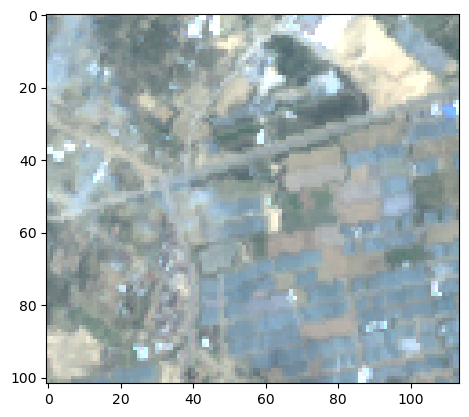

In [25]:
# Create RGB composite using B04 (red), B03 (green), and B02 (blue) bands
rgb = np.dstack([
    best.sel(band='B04').squeeze(),
    best.sel(band='B03').squeeze(),
    best.sel(band='B02').squeeze()
])

# Normalize each band to 0-1 range using 98th percentile
rgb_norm = np.zeros_like(rgb)
for i in range(3):
    rgb_norm[:,:,i] = rgb[:,:,i] / np.percentile(rgb[:,:,i], 98)

# Clip values to 0-1 range
rgb_norm = np.clip(rgb_norm, 0, 1)

# Display RGB composite
plt.imshow(rgb_norm)